# Q1. Downloading the data

In [1]:
import pandas as pd

In [2]:
jan = pd.read_parquet('fhv_tripdata_2021-01.parquet',engine='fastparquet')

In [3]:
jan.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,NaN,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,NaN,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,NaN,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,NaN,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,NaN,B00037


In [4]:
jan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154112 entries, 0 to 1154111
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   dispatching_base_num    1154112 non-null  object        
 1   pickup_datetime         1154112 non-null  datetime64[ns]
 2   dropOff_datetime        1154112 non-null  datetime64[ns]
 3   PUlocationID            195845 non-null   float64       
 4   DOlocationID            991892 non-null   float64       
 5   SR_Flag                 0 non-null        float64       
 6   Affiliated_base_number  1153227 non-null  object        
dtypes: datetime64[ns](2), float64(3), object(2)
memory usage: 61.6+ MB


In [6]:
jan = jan.drop('SR_Flag',axis = 1)

## Question 1: Number of records in Jan 2021 FHV data


In [7]:
len(jan)

1154112

# Q2. Computing duration

## Question 2: Average duration in Jan 2021 FHV



In [8]:
jan['duration'] = jan.dropOff_datetime - jan.pickup_datetime
jan.duration = jan.duration.apply(lambda td: td.total_seconds() / 60)

In [9]:
jan.duration.mean()

19.1672240937939

# Data Preparation

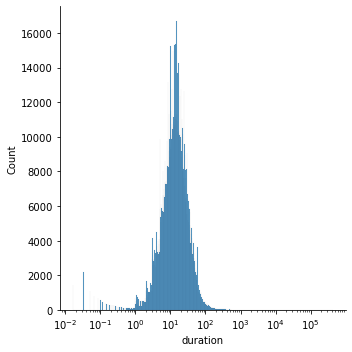

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(data=jan, x="duration",log_scale=True)
plt.show()

In [11]:
drop = len(jan[~(jan.duration >= 1)&(jan.duration <= 60)])
print('total dropped records:',drop)

total dropped records: 15024


In [12]:
jan = jan[(jan.duration >= 1)&(jan.duration <= 60)]

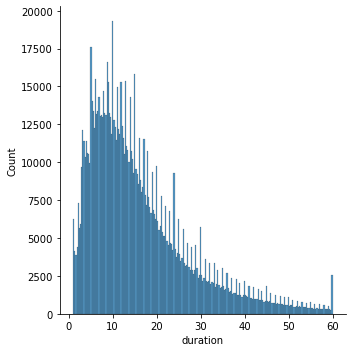

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(data=jan, x="duration")
plt.show()

# Q3. Missing values

## Question 3: Fraction of missing values



In [14]:
(jan.isnull().sum()/len(jan)).sort_values(ascending =False)[0]

0.8352732770722617

In [15]:
jan = jan.fillna(-1)

# Q4. One-hot encoding

In [16]:
categorical = ["PUlocationID", "DOlocationID"]
jan = jan[categorical + ["duration"]]

In [25]:
jan[categorical] = jan[categorical].astype(str)
train_dicts = jan[categorical].to_dict(orient='records')

In [26]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_train.shape

(1109826, 525)

# Q5. Training a model

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
y_train = jan.duration.values
lr.fit(X_train,y_train)

LinearRegression()

In [36]:
y_pred = lr.predict(X_train)
mean_squared_error(y_train,y_pred,squared=False)

10.528519107205959

# Q6. Evaluating the model

In [38]:
def read_df(file):
    df = pd.read_parquet(file,engine='fastparquet')
    
    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    df = df.fillna(-1)

    df = df[(df.duration >= 1)&(df.duration <= 60)]
    df = df[categorical + ["duration"]]
    df[categorical] = df[categorical].astype(str)
    
    return df

In [39]:
feb = read_df('fhv_tripdata_2021-02.parquet')

In [40]:
feb.head()

,PUlocationID,DOlocationID,duration
1,173.0,82.0,10.666667
2,173.0,56.0,14.566667
3,82.0,129.0,7.950000
4,-1.0,225.0,13.800000
5,-1.0,61.0,8.966667


In [41]:
test_dicts = feb[categorical].to_dict(orient='records')
X_test = dv.transform(test_dicts)
X_test.shape

(990113, 525)

In [43]:
y_test = feb.duration.values
y_pred_test = lr.predict(X_test)
mean_squared_error(y_test,y_pred_test,squared=False)

11.01428314240328